# Impacts of Landuse on Water Flow Peaks
by Martha Burket, Carson DeSotel  
GEOG 5543  
Fall 2021

In [60]:
'''
    Installation:
'''
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install requests

In [61]:
'''
    Imports:
'''
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
'''
    Open Saved Data & Validate
'''
final_data = pd.read_csv('final_data.csv')

### Convert Dates column to DateTime type
final_data['Dates'] = pd.to_datetime(final_data['Dates'], utc = True)

# print(df.head(10), df.tail(10))

In [63]:
'''
    Identify Max & Min Values
'''

columns = df.columns[1:] # exclude dates

for col in columns:
    print(col)
    print('Max:', df[col].max())
    print('Min:', df[col].min())
    print('----')

Temp (F)
Max: 97
Min: 6
----
RH (%)
Max: 100
Min: 15
----
Wind Spd (mph)
Max: 42
Min: 0
----
Precip (in)
Max: 1.95
Min: 0.0
----
Flow (ft^3 / s)
Max: 11900.0
Min: 23.9
----


In [64]:
'''
    Normalize Values:
'''

### Normalize RH by dividing by 100 to fit in range [0, 1]
final_data['RH (%)'] = final_data['RH (%)'].apply(lambda x: x / 100)

### Normalize Temp 
final_data['Temp (F)'] = final_data['Temp (F)'].apply(lambda x: x / 100)

### Normalize Precipitation
precip_max = final_data['Precip (in)'].max()
final_data['Precip (in)'] = final_data['Precip (in)'].apply(lambda x: x / precip_max)

### Normalize Wind Speed
wind_max = final_data['Wind Spd (mph)'].max()
final_data['Wind Spd (mph)'] = final_data['Wind Spd (mph)'].apply(lambda x: x / wind_max)

### Normalize Flow using Min-Max Normalization
flow_max = final_data['Flow (ft^3 / s)'].max()
flow_min = final_data['Flow (ft^3 / s)'].min()

final_data['Flow (ft^3 / s)'] = final_data['Flow (ft^3 / s)'].apply(lambda x: (x - flow_min) / (flow_max - flow_min))

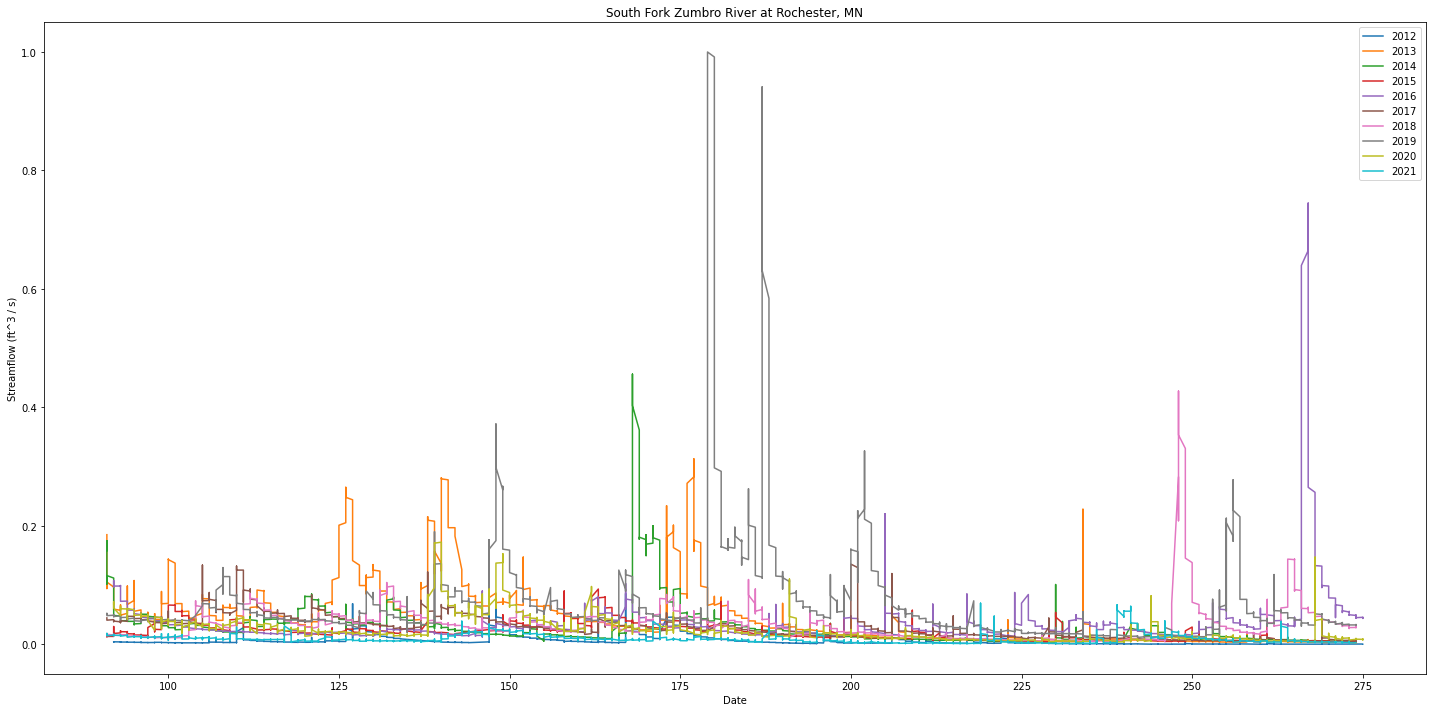

In [65]:
'''
    Plot Normalized Flow
'''

df_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(final_data[final_data['Dates'].dt.year == year].copy(deep = True))
    year += 1

plt.figure(figsize=(20, 10))
plt.title('South Fork Zumbro River at Rochester, MN')
plt.xlabel('Date')
plt.ylabel('Streamflow (ft^3 / s)')

index = 0
for df in df_arr:
    ### Remove Year From Datetime 'Dates' Column
    df['DayOfYear'] = df['Dates'].dt.dayofyear
    
    ### Plot Each DataFrame
    plt.plot(df['DayOfYear'], df['Flow (ft^3 / s)'], label=str(2012 + index))
    
    index += 1

plt.tight_layout()
plt.legend()
plt.show()


                      Dates  Temp (F)  RH (%)  Wind Spd (mph)  Precip (in)  \
0 2012-04-01 05:00:00+00:00      0.41    0.95        0.238095          0.0   
1 2012-04-01 06:00:00+00:00      0.41    1.00        0.190476          0.0   
2 2012-04-01 07:00:00+00:00      0.43    1.00        0.261905          0.0   
3 2012-04-01 08:00:00+00:00      0.46    0.92        0.214286          0.0   
4 2012-04-01 09:00:00+00:00      0.49    0.86        0.214286          0.0   
5 2012-04-01 10:00:00+00:00      0.54    0.77        0.261905          0.0   
6 2012-04-01 11:00:00+00:00      0.57    0.74        0.238095          0.0   
7 2012-04-01 12:00:00+00:00      0.60    0.66        0.309524          0.0   
8 2012-04-01 13:00:00+00:00      0.65    0.58        0.238095          0.0   
9 2012-04-01 14:00:00+00:00      0.66    0.58        0.261905          0.0   

   Flow (ft^3 / s)  DayOfYear  
0         0.003932         92  
1         0.003823         92  
2         0.003713         92  
3         0.0

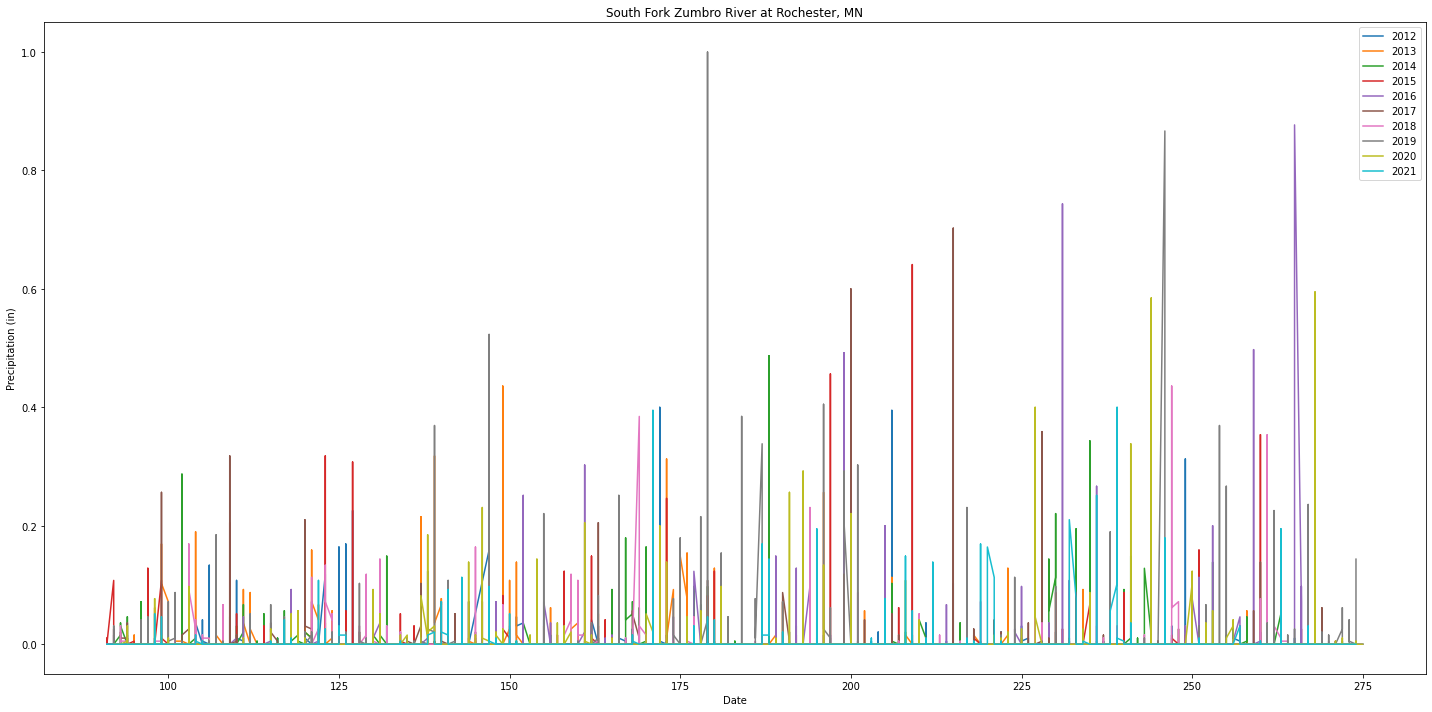

In [66]:
'''
    Display Precipitation
'''
df_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(final_data[final_data['Dates'].dt.year == year].copy(deep = True))
    year += 1

plt.figure(figsize=(20, 10))
plt.title('South Fork Zumbro River at Rochester, MN')
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')

index = 0
for df in df_arr:
    ### Remove Year From Datetime 'Dates' Column'Precip (in)'
    df['DayOfYear'] = df['Dates'].dt.dayofyear
    
    ### Plot Each DataFrame
    plt.plot(df['DayOfYear'], df['Precip (in)'], label=str(2012 + index))
    
    print(df.head(10))
    
    index += 1

plt.tight_layout()
plt.legend()
plt.show()

                      Dates  Temp (F)  RH (%)  Wind Spd (mph)  Precip (in)  \
0 2012-04-01 05:00:00+00:00      0.41    0.95        0.238095          0.0   
1 2012-04-01 06:00:00+00:00      0.41    1.00        0.190476          0.0   
2 2012-04-01 07:00:00+00:00      0.43    1.00        0.261905          0.0   
3 2012-04-01 08:00:00+00:00      0.46    0.92        0.214286          0.0   
4 2012-04-01 09:00:00+00:00      0.49    0.86        0.214286          0.0   
5 2012-04-01 10:00:00+00:00      0.54    0.77        0.261905          0.0   
6 2012-04-01 11:00:00+00:00      0.57    0.74        0.238095          0.0   
7 2012-04-01 12:00:00+00:00      0.60    0.66        0.309524          0.0   
8 2012-04-01 13:00:00+00:00      0.65    0.58        0.238095          0.0   
9 2012-04-01 14:00:00+00:00      0.66    0.58        0.261905          0.0   

   Flow (ft^3 / s)  DayOfYear  
0         0.003932         92  
1         0.003823         92  
2         0.003713         92  
3         0.0

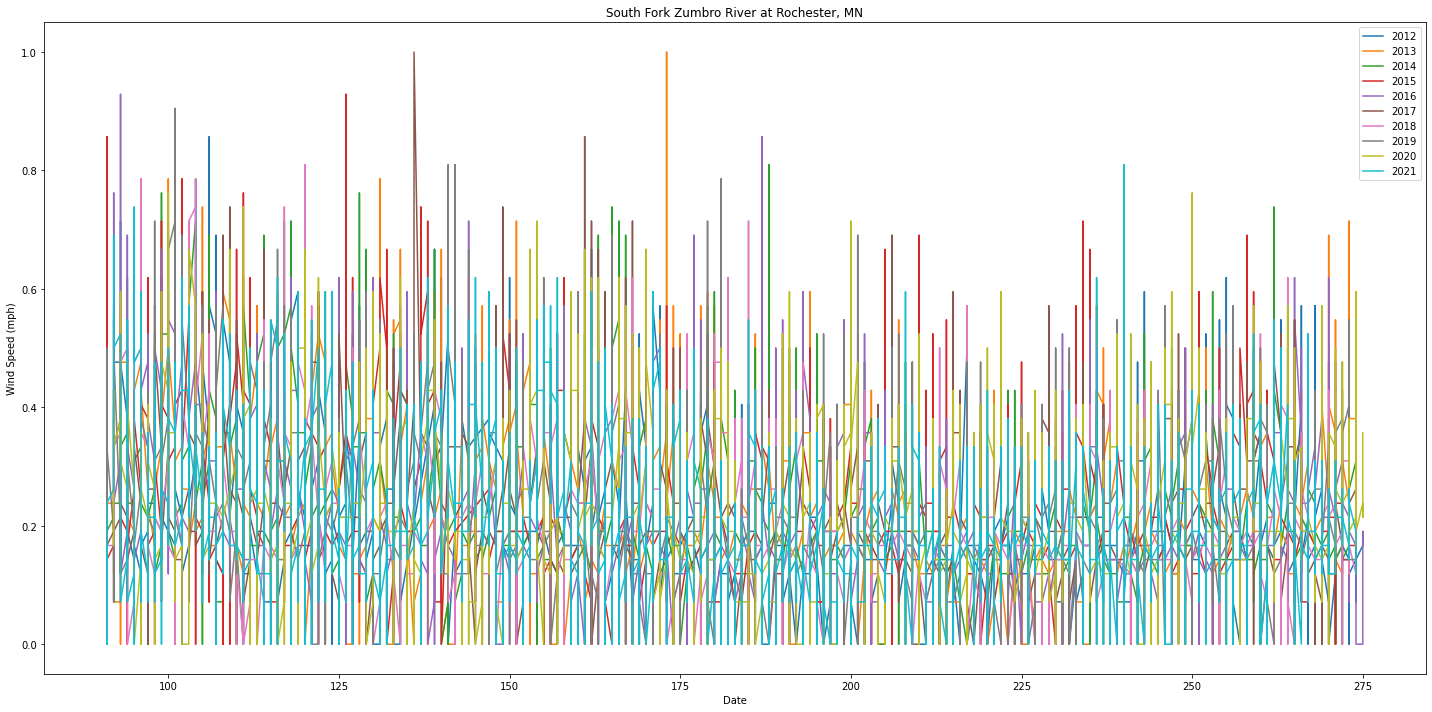

In [67]:
'''
    Display Normalized Wind Speed
'''
df_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(final_data[final_data['Dates'].dt.year == year].copy(deep = True))
    year += 1

plt.figure(figsize=(20, 10))
plt.title('South Fork Zumbro River at Rochester, MN')
plt.xlabel('Date')
plt.ylabel('Wind Speed (mph)')

index = 0
for df in df_arr:
    ### Remove Year From Datetime 'Dates' Column
    df['DayOfYear'] = df['Dates'].dt.dayofyear
    
    ### Plot Each DataFrame
    plt.plot(df['DayOfYear'], df['Wind Spd (mph)'], label=str(2012 + index))
    
    print(df.head(10))
    index += 1

plt.tight_layout()
plt.legend()
plt.show()

In [74]:
# add day of year to final data frame
final_data['DayOfYear'] = final_data['Dates'].dt.dayofyear

### References
[1] https://www.earthdatascience.org/tutorials/acquire-and-visualize-usgs-hydrology-data/  
[2] https://waterservices.usgs.gov/rest/IV-Service.html  
[3] https://www.ogc.org/standards/waterml  
[4] https://docs.python-requests.org/en/latest/user/quickstart/  
[5] https://www.usgs.gov/special-topic/water-science-school/science/how-streamflow-measured?qt-science_center_objects=0#qt-science_center_objects  


### Machine Learning

In [111]:
#!pip install sklearn
!pip install tensorflow
!pip install keras
import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=580ae63b7fc2e929188bbc33c3661a8dd72b866d4a7cf6ff22b93935c7c1d8c9
  Stored in directory: c:\users\marth\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor


In [129]:
# creating function to reshape data
def series_to_supervised(df, n_in=1, n_out=1,dropnan=True):
  n_vars = len(df.columns)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('%s (t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('%s (t)' % (df.columns[j])) for j in range(n_vars)]
    else:
      names += [('%s (t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # delete discontinuous rows of data - THIS WILL NOT WORK WHEN n_hours > 1
  agg['DayDiff'] = agg['DayOfYear (t-1)'].diff()
  agg = agg[abs(agg['DayDiff'])<=1]
  agg.drop(columns=['DayDiff'],inplace=True)

  if dropnan:
    agg.dropna(inplace=True)

  return agg

In [131]:
# will need to update to look back 3 hours
final_data.set_index(final_data['Dates'])
input_set = final_data.loc[:,'Temp (F)':'DayOfYear']
#n_hours = 3
n_features = 5
reframed = series_to_supervised(input_set,1,1)
#reframed.drop(reframed.columns[[4,6,7,8,9,11]], axis=1, inplace=True) # n_hours = 1
reframed.drop(reframed.columns[[4,5,10,11,16,17,18,19,20,21,23]], axis=1, inplace=True)
print(reframed.columns)

# maybe don't drop column 4

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(reframed[:5000])
reframed.head()

Index(['Temp (F) (t-3)', 'RH (%) (t-3)', 'Wind Spd (mph) (t-3)',
       'Precip (in) (t-3)', 'Temp (F) (t-2)', 'RH (%) (t-2)',
       'Wind Spd (mph) (t-2)', 'Precip (in) (t-2)', 'Temp (F) (t-1)',
       'RH (%) (t-1)', 'Wind Spd (mph) (t-1)', 'Precip (in) (t-1)',
       'Flow (ft^3 / s) (t)'],
      dtype='object')


,Temp (F) (t-3),RH (%) (t-3),Wind Spd (mph) (t-3),Precip (in) (t-3),Temp (F) (t-2),RH (%) (t-2),Wind Spd (mph) (t-2),Precip (in) (t-2),Temp (F) (t-1),RH (%) (t-1),Wind Spd (mph) (t-1),Precip (in) (t-1),Flow (ft^3 / s) (t)
3,0.41,0.95,0.238095,0.0,0.41,1.00,0.190476,0.0,0.43,1.00,0.261905,0.0,0.003713
4,0.41,1.00,0.190476,0.0,0.43,1.00,0.261905,0.0,0.46,0.92,0.214286,0.0,0.003823
5,0.43,1.00,0.261905,0.0,0.46,0.92,0.214286,0.0,0.49,0.86,0.214286,0.0,0.003932
6,0.46,0.92,0.214286,0.0,0.49,0.86,0.214286,0.0,0.54,0.77,0.261905,0.0,0.003932
7,0.49,0.86,0.214286,0.0,0.54,0.77,0.261905,0.0,0.57,0.74,0.238095,0.0,0.004042


In [114]:
values = reframed.values

# split into training and validation data
reframed['DayDiff'] = reframed['DayOfYear (t-1)'].diff()
yr_idx = reframed.index[abs(reframed['DayDiff'])>30].tolist()
# note that there are a few full days of missing data - stream gage out of commission
#print(yr_idx)
reframed.drop(columns=['DayDiff'],inplace=True)
split_idx = yr_idx[6]
train = values[:split_idx,:]
test = values[split_idx:,:]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(30260, 1, 5) (30260,) (13058, 1, 5) (13058,)


In [117]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
# can adjust the optimizer
model.compile(loss='mae', optimizer='adam')
# fit network
# can adjust the epochs, batch size
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
421/421 - 2s - loss: 0.0225 - val_loss: 0.0341 - 2s/epoch - 5ms/step
Epoch 2/50
421/421 - 1s - loss: 0.0194 - val_loss: 0.0335 - 670ms/epoch - 2ms/step
Epoch 3/50
421/421 - 1s - loss: 0.0198 - val_loss: 0.0393 - 660ms/epoch - 2ms/step
Epoch 4/50
421/421 - 1s - loss: 0.0190 - val_loss: 0.0394 - 677ms/epoch - 2ms/step
Epoch 5/50
421/421 - 1s - loss: 0.0189 - val_loss: 0.0372 - 661ms/epoch - 2ms/step
Epoch 6/50
421/421 - 1s - loss: 0.0182 - val_loss: 0.0398 - 668ms/epoch - 2ms/step
Epoch 7/50
421/421 - 1s - loss: 0.0180 - val_loss: 0.0399 - 650ms/epoch - 2ms/step
Epoch 8/50
421/421 - 1s - loss: 0.0177 - val_loss: 0.0377 - 770ms/epoch - 2ms/step
Epoch 9/50
421/421 - 1s - loss: 0.0180 - val_loss: 0.0366 - 674ms/epoch - 2ms/step
Epoch 10/50
421/421 - 1s - loss: 0.0184 - val_loss: 0.0388 - 670ms/epoch - 2ms/step
Epoch 11/50
421/421 - 1s - loss: 0.0179 - val_loss: 0.0348 - 682ms/epoch - 2ms/step
Epoch 12/50
421/421 - 1s - loss: 0.0183 - val_loss: 0.0351 - 686ms/epoch - 2ms/step
Epoc

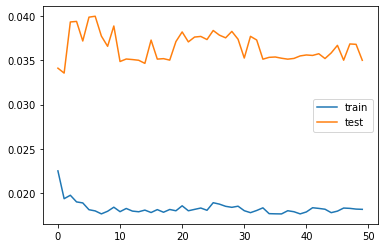

In [118]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()